# How to Train and Use Disentanglix: A Disentangled VAE

`Disentanglix` is a variant of the `Varix` pipeline that implements a **disentangled variational autoencoder**.  
Its key difference lies in the loss function, which decomposes the standard VAE loss into subcomponents to encourage disentanglement in the latent space with independent latent dimensions.


**IMPORTANT**

> This tutorial only shows the specifics of the Varix pipeline. If you're unfamiliar with general concepts,  
> we recommend following the `Getting Started - Vanillix` tutorial first.




## What You'll Learn

- How the loss decomposes into:
  - **Reconstruction loss** (`recon_loss`)  
  - **Mutual information** (`mut_info_loss`)  
  - **Total correlation** (`tot_corr_loss`)  
  - **Dimension-wise KL divergence** (`dimwise_kl_loss`)  
- How annealing can be applied to disentanglement weights (`beta_mi`, `beta_tc`, `beta_dimKL`)  
- How to initialize, run and visualize a disentangled VAE


## 1) Loss Decomposition

The `DisentanglixLoss` class computes the following terms for each batch:

1. **Reconstruction Loss** (`recon_loss`)  
   Measures how well the decoded output matches the input.

2. **Mutual Information Loss** (`mut_info_loss`)  
   Encourages each latent dimension to encode information about the inputs.

3. **Total Correlation Loss** (`tot_corr_loss`)  
   Penalizes correlations between latent dimensions to encourage independence.

4. **Dimension-wise KL Loss** (`dimwise_kl_loss`)  
   Regularizes each latent dimension individually against the prior.

The total loss is computed as a weighted sum:
```python
total_loss = recon_loss 
             + beta_mi * mut_info_loss 
             + beta_tc * tot_corr_loss 
             + beta_dimKL * dimwise_kl_loss
```

## 2) Annealing

Disentanglix supports flexible annealing strategies:

- no-annealing: uses constant weights throughout training

- Custom annealing functions: scales the disentanglement weights according to the current epoch

Annealing is applied independently to each loss term, allowing smooth transitions between reconstruction-focused and disentanglement-focused training.


## 3) Initialize and Run Disentagnlix
This works like `Varix`, except we don't have one `beta` parameter to weight the distribution loss, we have three `betas` one for each sub loss term which we can set a value for in the config.

In [1]:

from autoencodix.utils.example_data import EXAMPLE_MULTI_BULK
from autoencodix.configs.disentanglix_config import DisentanglixConfig
from autoencodix.configs.default_config import DataCase
import autoencodix as acx


my_cfg = DisentanglixConfig(
	data_case=DataCase.MULTI_BULK,
	loss_reduction="sum",
	k_filter=2000,
	latent_dim=2,
	scaling="STANDARD",
	epochs=200,
	learning_rate=0.0001,
	batch_size = 128,
	beta_mi = 1,
	beta_tc = 3000,
	beta_dimKL= 0.5,
	use_mss = True,
	drop_p =0.1,
	global_seed=42,
	checkpoint_interval=25,
	n_layers=1)

disent = acx.Disentanglix(data=EXAMPLE_MULTI_BULK, config=my_cfg)

in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>


In [2]:
result = disent.run()

anno key: transcriptomics
anno key: proteomics


/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/data/_filter.py:103: UserWarning: WARNING: k is None or greater than number of columns, keeping all features.
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/data/_filter.py:103: UserWarning: WARNING: k is None or greater than number of columns, keeping all features.
  warnings.warn(


Epoch 1 - Train Loss: 219.2309
Sub-losses: recon_loss: 219.2308, mut_info_loss: 0.0000, tot_corr_loss: 0.0001, dimwise_kl_loss: 0.0000, anneal_factor: 0.0000, effective_beta_mi_factor: 0.0000, effective_beta_tc_factor: 0.1362, effective_beta_dimKL_factor: 0.0000
Epoch 1 - Valid Loss: 195.6116
Sub-losses: recon_loss: 195.6091, mut_info_loss: 0.0000, tot_corr_loss: 0.0024, dimwise_kl_loss: 0.0000, anneal_factor: 0.0000, effective_beta_mi_factor: 0.0000, effective_beta_tc_factor: 0.1362, effective_beta_dimKL_factor: 0.0000
Epoch 2 - Train Loss: 216.8128
Sub-losses: recon_loss: 216.8122, mut_info_loss: 0.0000, tot_corr_loss: 0.0005, dimwise_kl_loss: 0.0000, anneal_factor: 0.0001, effective_beta_mi_factor: 0.0001, effective_beta_tc_factor: 0.1505, effective_beta_dimKL_factor: 0.0000
Epoch 2 - Valid Loss: 202.4665
Sub-losses: recon_loss: 202.4663, mut_info_loss: 0.0000, tot_corr_loss: 0.0002, dimwise_kl_loss: 0.0000, anneal_factor: 0.0001, effective_beta_mi_factor: 0.0001, effective_beta_tc_

#### 3.1) Obtain Results

This works as for other pipeline, but we have more sub-losses. See below:

In [3]:
result.sub_losses.keys()

dict_keys(['recon_loss', 'mut_info_loss', 'tot_corr_loss', 'dimwise_kl_loss', 'anneal_factor', 'effective_beta_mi_factor', 'effective_beta_tc_factor', 'effective_beta_dimKL_factor'])

#### 3.2) Visualize Results
In principle this also works the same as for `Varix`. However, me might be interested in a relative loss plot since we more different loss types.

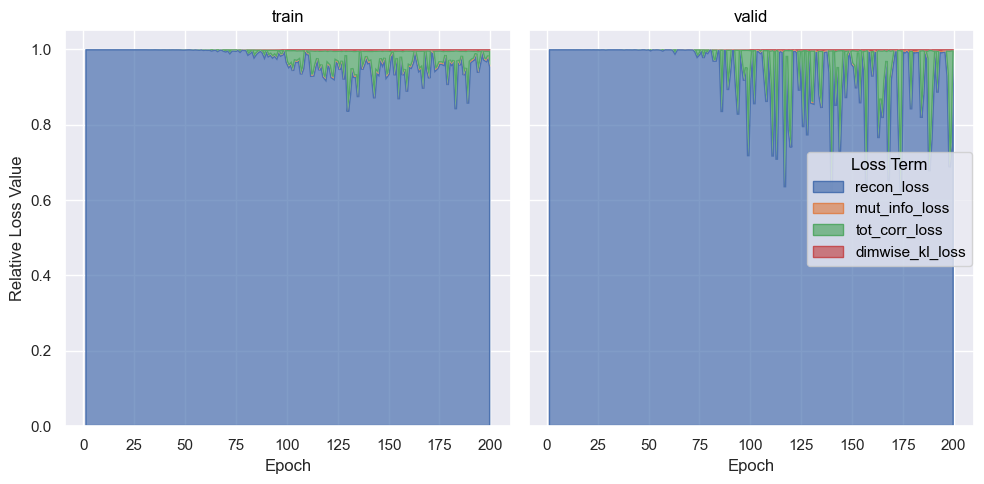

In [4]:

disent.visualizer.show_loss(plot_type="relative")

We can visualize our standard plots with `show_result`:


Creating plots ...


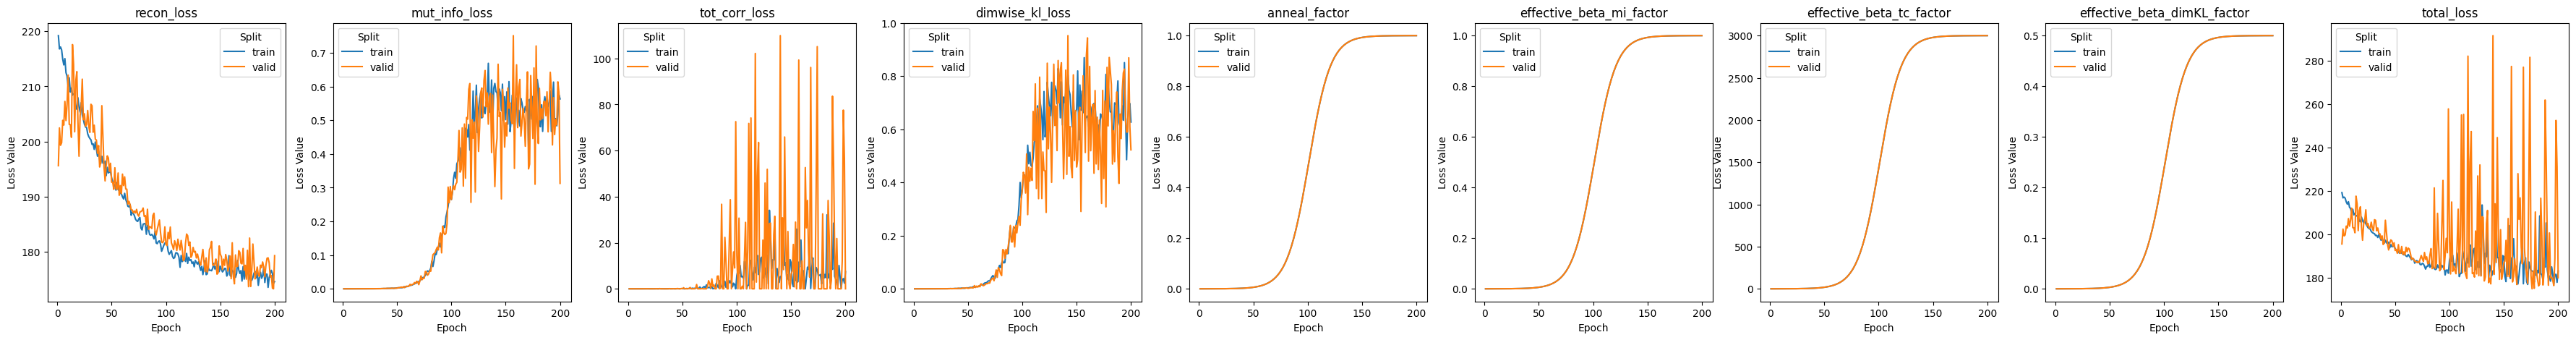

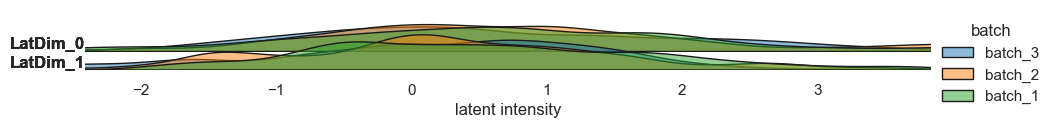

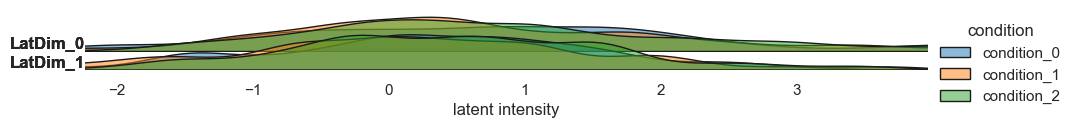

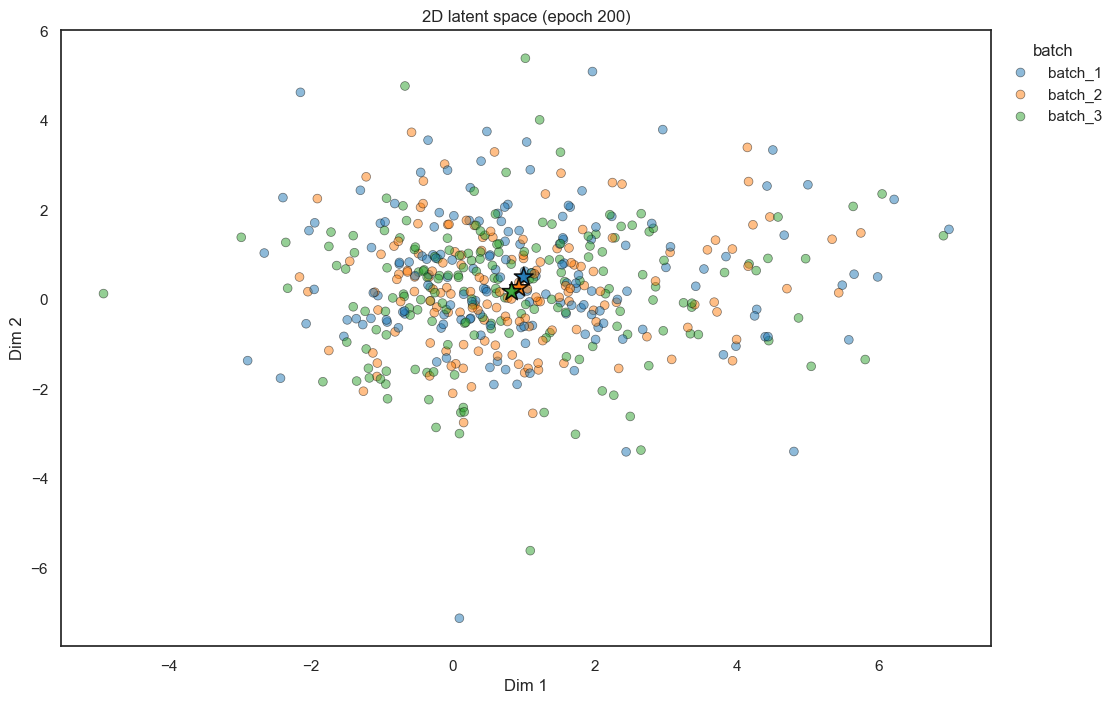

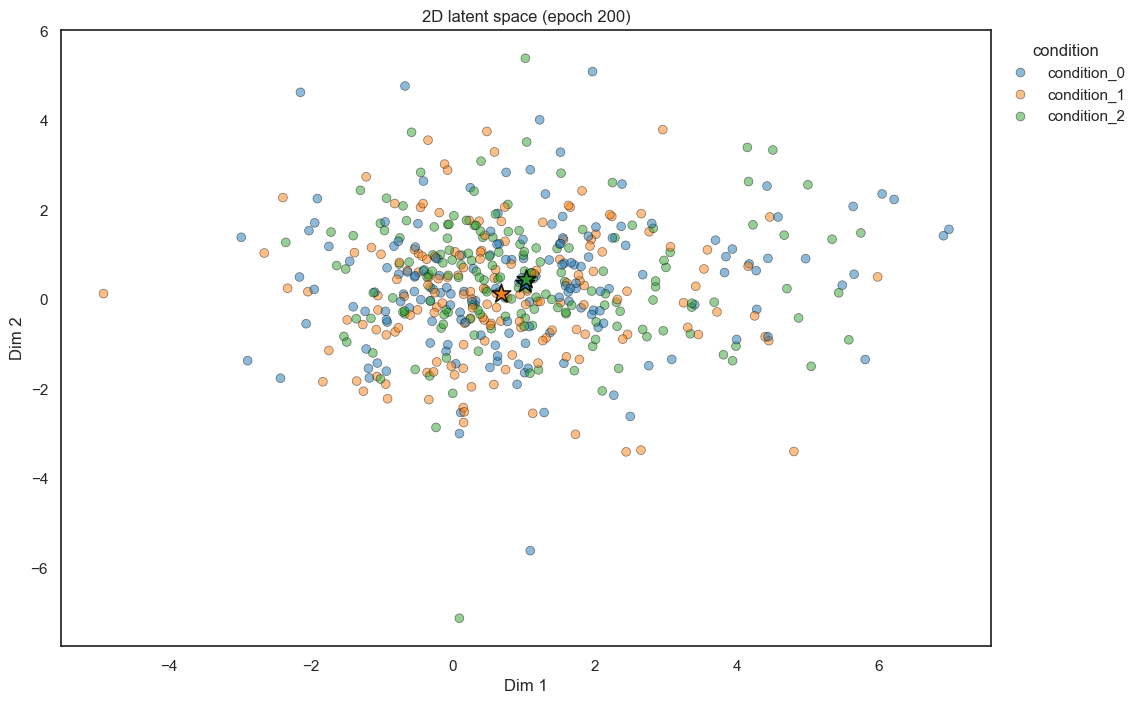

In [5]:

disent.show_result(params=["batch", "condition"])

#### 3.3) Save and Load Disentanglix

There are not `Disentanglix` specific steps here. See the `Getting Started - Vanillix` for details. Below is a basic save/load usecase:

In [6]:
import glob
import os
outpath = os.path.join("tutorial_res", "disent.pkl")
disent.save(file_path=outpath, save_all=True)

folder = os.path.dirname(outpath)
pkl_files = glob.glob(os.path.join(folder, "*.pkl"))
model_files = glob.glob(os.path.join(folder, "*.pth"))

print("PKL files:", pkl_files)
print("Model files:", model_files)

# the load functionality automatically will build the pipeline object out of the three saved files
disent_loaded = acx.Disentanglix.load(outpath)

Preprocessor saved successfully.
Pipeline object saved successfully.
PKL files: ['tutorial_res/stackix.pkl', 'tutorial_res/van_preprocessor.pkl', 'tutorial_res/varix.pkl', 'tutorial_res/van.pkl.pkl', 'tutorial_res/stackix_preprocessor.pkl', 'tutorial_res/van.pkl', 'tutorial_res/varix.pkl.pkl', 'tutorial_res/stackix.pkl.pkl', 'tutorial_res/varix_preprocessor.pkl']
Model files: ['tutorial_res/stackix_model.pth', 'tutorial_res/varix_model.pth', 'tutorial_res/van_model.pth']
Attempting to load a pipeline from tutorial_res/disent.pkl.pkl...
Pipeline object loaded successfully. Actual type: Disentanglix
Preprocessor loaded successfully.


In [7]:
disent_loaded.predict(data=EXAMPLE_MULTI_BULK)

in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>
n_samples in format recon: 500
train
n_samples from datatpackge: {'paired_count': 500}


Result Object Public Attributes:
------------------------------
latentspaces: TrainingDynamics object
sample_ids: TrainingDynamics object
reconstructions: TrainingDynamics object
mus: TrainingDynamics object
sigmas: TrainingDynamics object
losses: TrainingDynamics object
sub_losses: LossRegistry(_losses={'recon_loss': TrainingDynamics(), 'mut_info_loss': TrainingDynamics(), 'tot_corr_loss': TrainingDynamics(), 'dimwise_kl_loss': TrainingDynamics(), 'anneal_factor': TrainingDynamics(), 'effective_beta_mi_factor': TrainingDynamics(), 'effective_beta_tc_factor': TrainingDynamics(), 'effective_beta_dimKL_factor': TrainingDynamics()})
preprocessed_data: Tensor of shape (0,)
model: VarixArchitecture
model_checkpoints: TrainingDynamics object
datasets: DatasetContainer(train=<autoencodix.data._numeric_dataset.NumericDataset object at 0x15a8f1280>, valid=<autoencodix.data._numeric_dataset.NumericDataset object at 0x15a6615e0>, test=<autoencodix.data._numeric_dataset.NumericDataset object at 0x

Creating plots ...


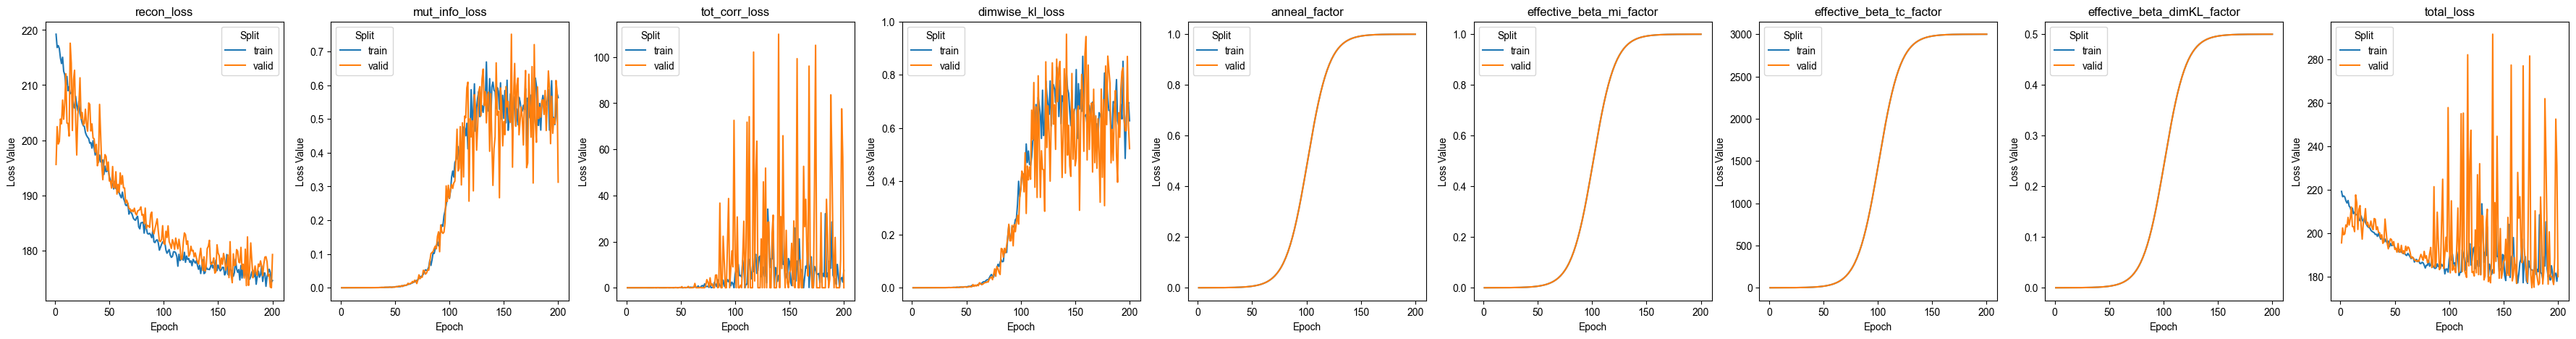

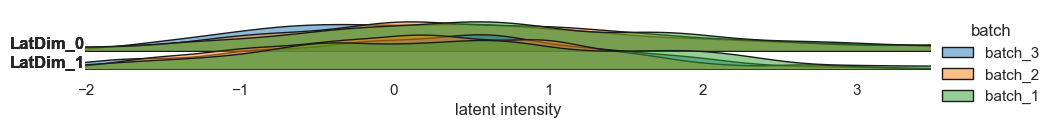

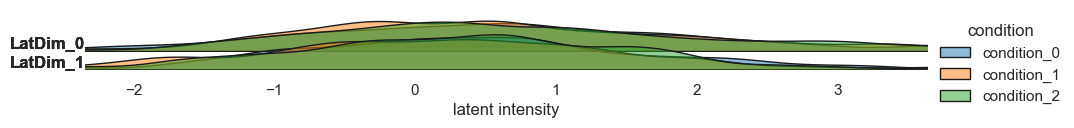

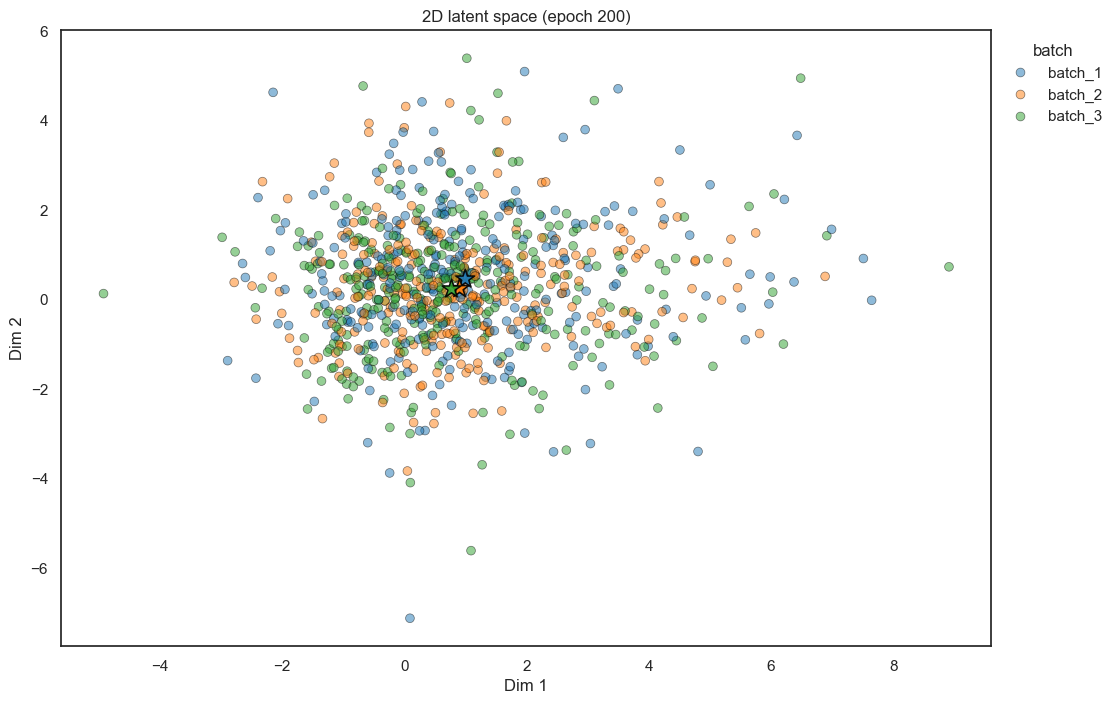

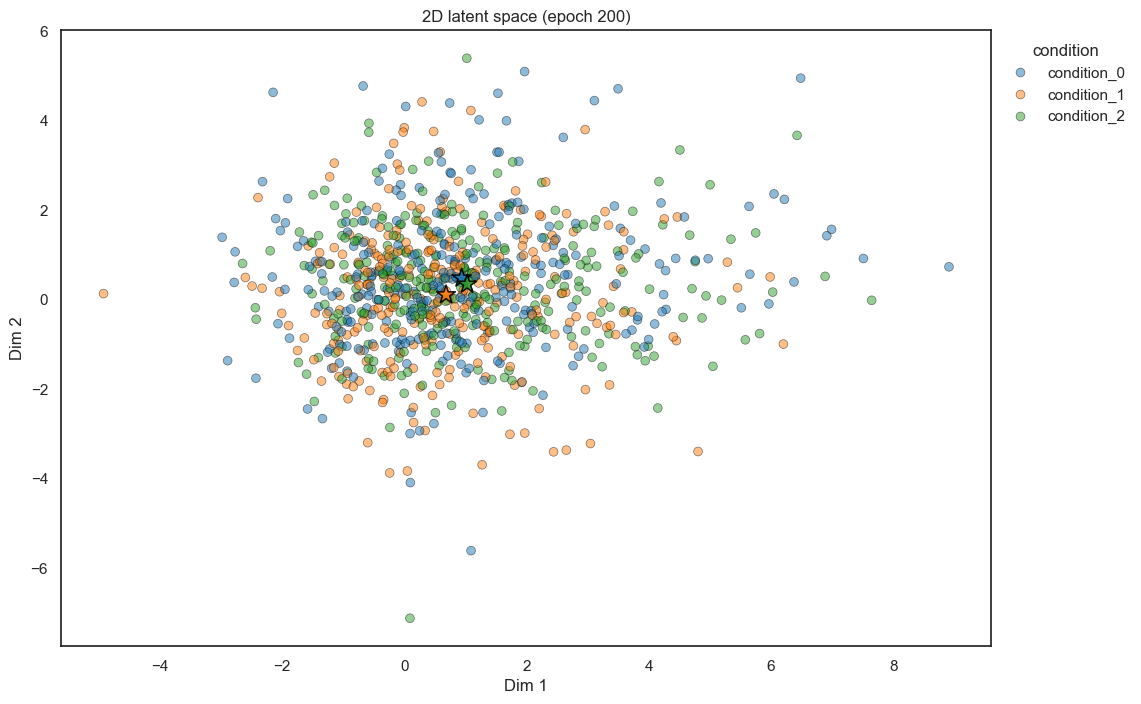

In [8]:

disent_loaded.show_result(params=["batch", "condition"])

#### Generate New Data
For a variational autoencoder, the generate or sample_latent_space step draws new latent vectors from the model’s learned latent distribution.

**Latent Sampling:** 
The model first aggregates the posterior over all encoded latent vectors in the chosen split and epoch by computing the mean (global_mu) and log-variance (global_logvar). It then samples new latent points from a diagonal Gaussian defined by these aggregate statistics, using the reparameterization trick to inject Gaussian noise.

**Number of Samples (n_samples):** 
Users can specify how many latent points to generate. The method expands the aggregated mean and log-variance to match the requested number of samples before sampling.

**Custom Latent Prior:** 
Optionally, a custom latent_prior can be provided (a tensor or NumPy array with shape (n_samples, latent_dim)), which will be used directly instead of the aggregated posterior. This is basically the `decode` step.


In [9]:
reconstructions_generated = disent_loaded.generate(n_samples=5)
print(reconstructions_generated.shape)

torch.Size([5, 180])
